# Wine dataset

In [1]:
import csv
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud

from src.consts.wine import CORE_DESCRIPTORS, VARIETY_MAPPING
from src.data_preprocessing.text_preprocessing import (
    calculate_tfidf_embeddings,
    extract_phrases,
    normalize_nonaromas,
    normalize_sentences,
    wine_food_word2vec,
)

## Exploratory Data Analysis

In [2]:
wine_dir = "../data/wine"
all_wines = glob.glob(os.path.join(wine_dir, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_wines), ignore_index=True)

In [20]:
df.columns

Index(['Unnamed: 0', 'Alcohol', 'Appellation', 'Bottle Size', 'Category',
       'Country', 'Date Published', 'Description', 'Designation', 'Importer',
       'Name', 'Price', 'Province', 'Rating', 'Region', 'Reviewer',
       'Reviewer Twitter Handle', 'Subregion', 'User Avg Rating', 'Variety',
       'Vintage', 'Winery'],
      dtype='object')

In [3]:
df = df[["Category", "Country", "Description", "Name", "Province", "Region", "Subregion", "Variety"]]
df.head()

,Category,Country,Description,Name,Province,Region,Subregion,Variety
0,Red,US,This red is brightly layered in fresh blue fru...,Westwood 2016 Legend Red (Sonoma Valley),California,Sonoma,Sonoma Valley,"Red Blends, Red Blends"
1,Red,US,"Fantastic purple-leaning aromas of acia, elder...",Refugio Ranch 2016 Barbareño Syrah-Petite Sira...,California,Central Coast,Santa Ynez Valley,"Syrah-Petite Sirah, Red Blends"
2,Red,France,"From selected parcels and aged in wood, this w...",Les Vignobles Gueissard 2016 Cuvée Marcel Red ...,Provence,Bandol,NaN,"Provence red blend, Red Blends"
3,Red,Chile,Ventisquero may make more expensive wines but ...,Ventisquero 2014 Vertice Apalta Vineyard Carme...,Colchagua Valley,NaN,NaN,"Carmenère-Syrah, Red Blends"
4,Red,France,"This wine is produced from organic grapes, woo...",Domaine de la Bégude 2016 La Brulade Red (Bandol),Provence,Bandol,NaN,"Provence red blend, Red Blends"


### General EDA

In [32]:
df.describe()

,Category,Country,Description,Name,Province,Region,Subregion,Variety
count,145396,145203,144780,145396,145197,120963,53090,145202
unique,7,47,144206,143753,488,1060,226,366
top,Red,US,Review unavailable at this time,Ruinart NV Blanc de Blancs Brut Chardonnay (Ch...,California,Columbia Valley,Columbia Valley (WA),Pinot Noir
freq,95861,54495,70,8,27089,13085,6973,17748


We may notice that there are some review missing (`Review unavailable at this time`), such rows provide no useful information.

Also a lot of values are missing for `Subregion` and `Region`, it may be useful to merge all localization features into one. We will also drop rows with NaN in name or description.

In [4]:
df = df[df.Description != "Review unavailable at this time"]
df = df.dropna(subset=["Name", "Description"], how="any")
df = df.drop_duplicates()

In [6]:
df.describe()

,Category,Country,Description,Name,Province,Region,Subregion,Variety
count,144261,144070,144262,144262,144064,120191,52817,144069
unique,7,47,144204,143070,488,1055,226,366
top,Red,US,"Stalky aromas suggest hay and green herbs, wit...",Ruinart NV Blanc de Blancs Brut Chardonnay (Ch...,California,Columbia Valley,Columbia Valley (WA),Pinot Noir
freq,95262,54213,2,7,26989,13051,6956,17535


### Reviews

In [7]:
reviews = list(df["Description"])

Process reviews (tokenize + normalize)

In [8]:
full_corpus = " ".join([str(r) for r in reviews])
tokenized = sent_tokenize(full_corpus)
tokenized[0]

'This red is brightly layered in fresh blue fruit, meat and garrigue, showing plenty of density and complexity.'

In [9]:
reviews_normalized = normalize_sentences(tokenized)
reviews_normalized[0]

['red',
 'bright',
 'layer',
 'fresh',
 'blue',
 'fruit',
 'meat',
 'garrigu',
 'show',
 'plenti',
 'densiti',
 'complex']

Extract n-grams

In [10]:
reviews_phrases = extract_phrases(reviews_normalized, save_path="../data/wine_trigrams.pkl")
reviews_phrases[0]

['red',
 'bright',
 'layer',
 'fresh',
 'blue',
 'fruit',
 'meat',
 'garrigu',
 'show',
 'plenti',
 'densiti',
 'complex']

In [12]:
with open("../data/wine_phrases.csv", 'w') as f:
    write = csv.writer(f)
    write.writerows(reviews_phrases)

Stats (wordmap)

In [25]:
words_all = [word for sublist in reviews_normalized for word in sublist]
words_all_text = " ".join(words_all)

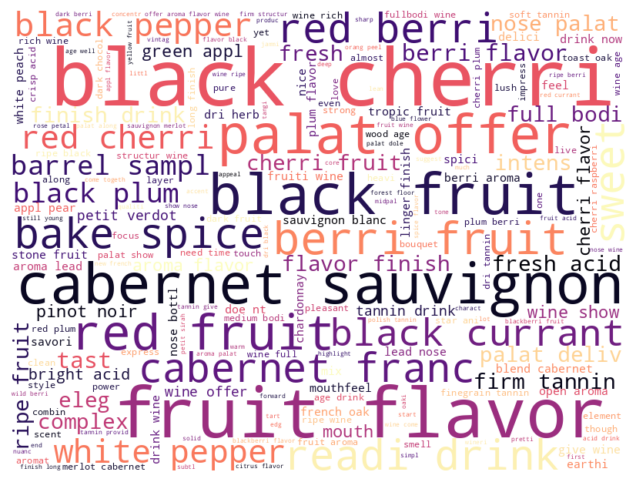

In [28]:
wc = WordCloud(
    width=800, height=600, max_words=200, background_color="white", colormap="magma"
).generate(words_all_text)
plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data preprocessing

In [74]:
# NOTE: THIS IS JUST A SUGGESTION (I haven't changed the code, this might be deleted later)
descriptor_mapping_aromas = pd.read_csv(
    "../data/descriptor_mapping_aromas.csv", encoding="latin1"
).set_index("raw descriptor")

descriptor_mapping_tastes = pd.read_csv(
    "../data/descriptor_mapping_tastes.csv", encoding="latin1"
).set_index("raw descriptor")

descriptor_mapping_tastes = descriptor_mapping_tastes[["level_3","level_2", "level_1", "type"]]

print("AROMAS - TASTES:")
diff_aromas = set(descriptor_mapping_aromas.index).difference(set(descriptor_mapping_tastes.index))
print(diff_aromas)

print("TASTES - AROMAS:")
diff_tastes = set(descriptor_mapping_tastes.index).difference(set(descriptor_mapping_aromas.index))
print(diff_tastes)

descriptor_mapping_aromas = descriptor_mapping_aromas[~descriptor_mapping_aromas.index.isin(diff_aromas)]
descriptor_mapping_tastes = descriptor_mapping_tastes[~descriptor_mapping_tastes.index.isin(diff_tastes)]
print(f"\nThe datsaets are the same:\n{descriptor_mapping_aromas.all() == descriptor_mapping_tastes.all()}")
# for the differences between the two sets, we will use the mapping from the taste dataset;
# they were checked manually and besides special characters, the rest is the same 
# - in fact due to normalization I'd remove special characters as they won't match anything in sucha a form so we can use:
from unidecode import unidecode

def replace_non_latin(df: pd.DataFrame) -> pd.DataFrame:
    df.index = df.index.map(unidecode)
    return df
# we loose only 'chewi' from aroma dataset so imo it's wise to keep only descriptor_mapping_tastes
# therefore I'd rename descriptor_mapping_tastes to descriptor_mapping_all and use it everywhere

AROMAS - TASTES:
{'jalapeÃ\x83Â±o', 'jalapeÃ\x83Â£Ã\x82Â±o', 'chewi', 'crÃ¨me_brulee'}
TASTES - AROMAS:
{'jalapeÃ£Â±o', 'jalapeÃ±o', 'crème_brulee'}

The datsaets are the same:
level_3    True
level_2    True
level_1    True
type       True
dtype: bool


### Wine theory
We will use wine descriptors mapping based on UC Davis wine wheel. Source: https://github.com/RoaldSchuring/wine_food_pairing/blob/master/descriptor_mapping.csv
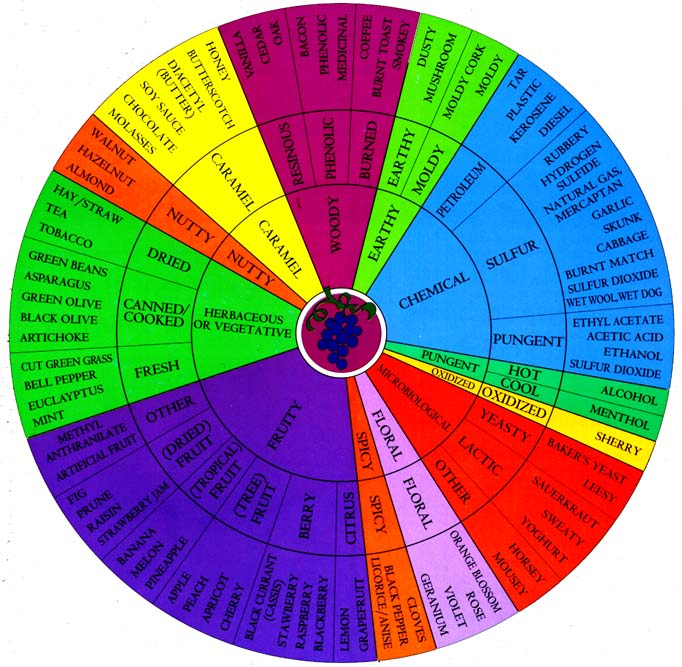

We will combine wine descriptors with our dataset, using Word2Vec model.

In [2]:
with open("../data/wine_phrases.csv", "r") as f:
    csv_reader = csv.reader(f)
    wine_phrases = list(csv_reader)

with open("../data/food_phrases.csv", "r") as f:
    csv_reader = csv.reader(f)
    food_phrases = list(csv_reader)

descriptor_mapping = pd.read_csv(
    "../data/descriptor_mapping_aromas.csv", encoding="latin1"
).set_index("raw descriptor")

In [3]:
model_path = "../data/word2vec.bin"
wine_food_word2vec(wine_phrases, food_phrases, descriptor_mapping, model_path)

### Geography cleaning
Merging location into one meaningful column.

In [5]:
df = df.fillna(value={"Region": "", "Province": ""})
df[["Region", "Province", "Country"]] = df[["Region", "Province", "Country"]].astype(str)
df["Location"] = df[["Region", "Province", "Country"]].agg(", ".join, axis=1)
df = df.drop(["Country", "Subregion", "Province", "Region", "Category"], axis=1)
df.head()

,Description,Name,Variety,Location
0,This red is brightly layered in fresh blue fru...,Westwood 2016 Legend Red (Sonoma Valley),"Red Blends, Red Blends","Sonoma, California, US"
1,"Fantastic purple-leaning aromas of acia, elder...",Refugio Ranch 2016 Barbareño Syrah-Petite Sira...,"Syrah-Petite Sirah, Red Blends","Central Coast, California, US"
2,"From selected parcels and aged in wood, this w...",Les Vignobles Gueissard 2016 Cuvée Marcel Red ...,"Provence red blend, Red Blends","Bandol, Provence, France"
3,Ventisquero may make more expensive wines but ...,Ventisquero 2014 Vertice Apalta Vineyard Carme...,"Carmenère-Syrah, Red Blends",", Colchagua Valley, Chile"
4,"This wine is produced from organic grapes, woo...",Domaine de la Bégude 2016 La Brulade Red (Bandol),"Provence red blend, Red Blends","Bandol, Provence, France"


Keeping only frequent variety + location combinations.

In [6]:
df = df[df.groupby(["Variety", "Location"]).transform("size") > 30]
df.describe()

,Description,Name,Variety,Location
count,119381,119381,119381,119381
unique,119333,118358,66,292
top,"Subtle aromas of dark berry, tilled earth and ...",Ruinart NV Blanc de Blancs Brut Chardonnay (Ch...,Pinot Noir,"Columbia Valley, Washington, US"
freq,2,7,15882,12730


### Non-aromas
Calculate non-aroma descriptors

In [7]:
wine_reviews = list(df["Description"])
descriptor_mapping = pd.read_csv(
    "../data/descriptor_mapping_tastes.csv", encoding="latin1"
).set_index("raw descriptor")
wine_trigram_model = Phraser.load("../data/wine_trigrams.pkl")

review_descriptors = normalize_nonaromas(
    wine_reviews, descriptor_mapping, wine_trigram_model
)

Calculate TF-IDF embeddings for each wine, using aroma and nonaroma vectors.

In [11]:
model_path = "../data/word2vec.bin"
wine_word2vec_model = Word2Vec.load(model_path)
wine_df_vecs = calculate_tfidf_embeddings(
    df, review_descriptors, wine_word2vec_model
)
wine_df_vecs.head()

,Description,Name,Variety,Location,aroma_descriptors,weight_descriptors,sweet_descriptors,acid_descriptors,salt_descriptors,piquant_descriptors,fat_descriptors,bitter_descriptors,aroma,weight,sweet,acid,salt,piquant,fat,bitter
0,This red is brightly layered in fresh blue fru...,Westwood 2016 Legend Red (Sonoma Valley),"Red Blends, Red Blends","Sonoma, California, US","[fruit, meat, pepper]",[],[],"[high_acid, high_acid]",[],[pepper],[],[],"[-1.3758382, -5.450079, -0.098828875, 2.674193...",NaN,NaN,"[0.17378671, -0.30570734, 0.41627336, 0.079696...",NaN,"[-1.0088462, -3.0634787, -1.8228809, 2.5051415...",NaN,NaN
5,"Ripe, spicy and elegant from the start, this C...",Vik 2014 Milla Cala Red (Cachapoal Valley),"Red Blends, Red Blends",", Cachapoal Valley, Chile","[ripe, fruit, tar, prune, fruit]",[full_bodied],[],[],[],[],[],"[high_tannin, high_tannin, high_tannin]","[-0.06395958, -2.2423224, -0.48585358, 2.68514...","[1.9947494, -1.3891122, -0.30079675, 0.6917901...",NaN,NaN,NaN,NaN,NaN,"[0.32431242, 0.16549398, 0.29168087, 0.9091007..."
6,"Aromas of roasted blackberry, coffee, açaí and...",Westerly 2016 Fletcher's Red (Happy Canyon of ...,"Red Blends, Red Blends","Central Coast, California, US","[cured_meat, cherry, wood, spice, tobacco, van...",[full_bodied],[dry],[],[],[],[],[low_tannin],"[-0.04097997, -3.0765295, -0.04319333, 0.98460...","[1.9947494, -1.3891122, -0.30079675, 0.6917901...","[4.6685824, -0.69186753, -3.7409801, 6.0666566...",NaN,NaN,NaN,NaN,NaN
7,Bold black currant and wild berry aromas are m...,Casa Donoso 2015 Sucesor Blue Limited Release ...,"Red Blends, Red Blends",", Maule Valley, Chile","[juicy, plum, blueberry, smoke, oak, juicy, cr...",[light_bodied],[],"[high_acid, high_acid]",[],[],[],"[high_tannin, low_tannin]","[0.78618735, -3.6675735, -3.506054, 2.8821585,...","[1.6662782, -5.3991385, -2.7527623, 1.3662342,...",NaN,"[0.17378671, -0.30570734, 0.41627336, 0.079696...",NaN,NaN,NaN,"[0.32431242, 0.16549398, 0.29168087, 0.9091006..."
9,Despite a saturated black color and deep aroma...,Santa Carolina 2014 VSC Red (Cachapoal Valley),"Red Blends, Red Blends",", Cachapoal Valley, Chile","[lavender, pepper, roast_beef, elderberry, jui...",[full_bodied],[],[],[],[pepper],[],[],"[0.12132827, -4.1991777, -2.2819662, 3.2750587...","[1.9947494, -1.3891122, -0.30079675, 0.6917901...",NaN,NaN,NaN,"[-1.0088462, -3.0634787, -1.8228809, 2.5051415...",NaN,NaN


Replace NaNs with average of columms

In [ ]:
wine_df_vecs[CORE_DESCRIPTORS] = wine_df_vecs[CORE_DESCRIPTORS].fillna(
    value=wine_df_vecs.mean()
)
wine_df_vecs.head()

In [12]:
wine_df_vecs.to_pickle("../data/wine_df_vecs.pkl")